In [1]:
from typing import List
import itertools as it
import re
from math import log
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import stim
import pymatching

In [17]:
def matching_graph(d: int, probabilities: List[float]) -> nx.Graph:
    """Get the matching graph for the repetition code.
    
    Arguments:
    d - Distance of the code. Should be odd.
    probabilities - A list of bit-flip probablities.
    
    Returns:
    M - The matching graph for this code and error model."""

    assert d >= 3, f"Distance must be >= 3, but got {d}."
    assert d % 2 != 0, f"Distance d must be odd, but got {d}."
    assert len(probabilities) == d, f"Got {len(probabilities)} probabilities at d={d}."

    matching_graph = nx.Graph()
    # First add the "extra nodes" for the leftmost and rightmost qubits.
    matching_graph.add_node("r1")
    matching_graph.add_node("r2")
    # Then add the regular syndromes
    for i in range(d - 1):
        matching_graph.add_node(f"s{i}")
    # Add an edge of weight w = log((1-p_i)/p_i) for each qubit.
    for i in range(d):
        w = log((1. - probabilities[i]) / probabilities[i])
        if i == 0:
            matching_graph.add_edge("r1", "s0", weight=w, label="q0")
        elif i == d - 1:
            matching_graph.add_edge("r2", f"s{i-1}", weight=w, label=f"q{i}")
        else:
            matching_graph.add_edge(f"s{i-1}", f"s{i}", weight=w, label=f"q{i}")
    return matching_graph

In [18]:
def error_to_syndrome(err: np.ndarray) -> np.ndarray:
    """Convert a list of bit-flips into a the repetition code syndrome."""

    d = err.size
    check = np.zeros((d-1, d), dtype=bool)
    for i in range(d - 1):
        check[i, i] = True
        check[i, i + 1] = True
    return ((check.astype(int) @ err.astype(int)) % 2).astype(bool)

In [19]:
def enumerate_syndrome_graphs(matching: nx.Graph, syndrome: np.ndarray) -> List[nx.Graph]:
    """Gets the syndrome graphs for a binary syndrome vector given the matching graph.
    Depending on whether the syndrome has odd or even Hamming weight, the extra nodes need
    to be included differently. For even Hamming weight, the syndrome graph either needs
    both extra nodes or neither of them. For odd Hamming weight, the syndrome graph needs
    either the left or the right extra node. We will find a matching for both graphs
    and choose the correction with the lower weight."""

    d = len(matching.nodes()) - 1
    assert syndrome.size == d - 1

    # Build a graph with a node for each 1 in the syndrome.
    syndrome_gr = nx.Graph()
    for i, b in enumerate(syndrome):
        if b:
            syndrome_gr.add_node(f"s{i}")
    
    syndrome_graphs_with_extras = []
    if sum(syndrome) % 2 == 0:
        # One syndrome graph will have no extra nodes.
        syndrome_graphs_with_extras.append(syndrome_gr.copy())
        # The other will have both.
        syndrome_graphs_with_extras.append(syndrome_gr.copy())
        syndrome_graphs_with_extras[1].add_node("r1")
        syndrome_graphs_with_extras[1].add_node("r2")
    else:
        # One syndrome graph will have the left node.
        syndrome_graphs_with_extras.append(syndrome_gr.copy())
        syndrome_graphs_with_extras[0].add_node("r1")
        # The other will have the right one.
        syndrome_graphs_with_extras.append(syndrome_gr.copy())
        syndrome_graphs_with_extras[1].add_node("r2")

    for this_syndrome_gr in syndrome_graphs_with_extras:
        assert set(this_syndrome_gr.nodes()).issubset(matching.nodes())
        assert len(this_syndrome_gr.nodes) % 2 == 0
        for sn1 in this_syndrome_gr.nodes():
            for sn2 in this_syndrome_gr.nodes():
                if sn1 != sn2:
                    length = nx.shortest_path_length(matching, sn1, sn2, weight='weight')
                    this_syndrome_gr.add_edge(sn1, sn2, weight=length)
    return syndrome_graphs_with_extras

In [20]:
def repetition_tanner_graph(d: int) -> nx.Graph:
    """Get the Tanner graph for a repetition code."""

    assert d % 2 != 0
    assert d >= 3

    tanner_graph = nx.Graph()
    for i in range(d):
        tanner_graph.add_node(f"q{i}")
        if i == 0:
            tanner_graph.add_node(f"r1")
            tanner_graph.add_node(f"s0")
            tanner_graph.add_edge("q0", "r1")
            tanner_graph.add_edge("q0", "s0")
        elif i == d - 1:
            tanner_graph.add_node("r2")
            tanner_graph.add_edge(f"q{i}", "r2")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
        else:
            tanner_graph.add_node(f"s{i}")
            tanner_graph.add_edge(f"q{i}", f"s{i - 1}")
            tanner_graph.add_edge(f"q{i}", f"s{i}")
    return tanner_graph

In [21]:
def matching_to_correction(matching, matching_gr, tanner_graph) -> np.ndarray:
    """Convert the minimum-weight matching to a binary correction."""

    def qubit_for_syndrome_pair(s1, s2):
        s1_neighbors = set(tanner_graph.neighbors(s1))
        s2_neighbors = set(tanner_graph.neighbors(s2))
        shared_nodes = s1_neighbors & s2_neighbors
        assert len(shared_nodes) == 1, f"{s1_neighbors} {s2_neighbors}"
        q_name = list(shared_nodes)[0]
        idx = int(re.search(r'\d+', q_name).group()) 
        return idx

    # Count qubits in the Tanner graph.
    nq = 0
    for node in tanner_graph.nodes():
        if 'q' in node:
            nq += 1

    correction = [False] * nq
    for n1, n2 in matching:
        # Get a path from n1 to n2 on the matching graph.
        # Each edge on the path will give us a qubit.
        path = nx.shortest_path(matching_gr, n1, n2)
        for i in range(len(path) - 1):
            s1 = path[i]
            s2 = path[i+1]
            idx = qubit_for_syndrome_pair(s1, s2)
            # correction[idx] = True
            correction[idx] ^= True
    return np.array(correction)

In [33]:
def syndrome_to_correction(syndrome: np.ndarray, probabilities: np.ndarray) -> np.ndarray:
    """Map a syndrome to a correction given an error model."""

    d = len(syndrome) + 1
    tanner_gr = repetition_tanner_graph(d)
    matching_gr = matching_graph(d, probabilities)
    syndrome_graphs = enumerate_syndrome_graphs(matching_gr, syndrome)

    corrections = []
    correction_weights = []
    for syndrome_gr in syndrome_graphs:
        # print("Syndrome graph nodes:\n", syndrome_gr.nodes)
        matching = nx.min_weight_matching(syndrome_gr)
        correction = matching_to_correction(matching, matching_gr, tanner_gr)
        corrections.append(correction)
        correction_weights.append(np.sum(correction))
    min_weight_idx = np.argmin(correction_weights)
    min_weight_correction = corrections[min_weight_idx]
    
    # Check that the correction has the same syndrome as we passed in.
    correction_syndrome = error_to_syndrome(min_weight_correction)
    if not np.array_equal(syndrome, correction_syndrome):
        raise ValueError(f"Correction {min_weight_correction} has syndrome {correction_syndrome} but syndrome {syndrome} was passed.")

    return min_weight_correction

In [34]:
d = 5
probs = np.array([0.1] * d)
err = np.array([False, True, False, True, False])
syndrome = error_to_syndrome(err)
correction = syndrome_to_correction(syndrome, probs)
print("Correction =", correction)

Correction = [False  True False  True False]


## Test all errors of a certain weight.

At $d=3$, we can correct all single-qubit bit flip errors. At $d=5$, we can correct all two-qubit bit flip errrors.

In [36]:
d = 3
probs = np.array([0.1] * d)

for inds in it.combinations(range(d), 1):
    err = np.array([False] * d, dtype=bool)
    for ind in inds:
        err[ind] = True
    print("Error:", err)
    syndrome = error_to_syndrome(err)
    print("Syndrome:", syndrome)
    correction = syndrome_to_correction(syndrome, probs)
    print("Corretion:", correction)
    assert np.all(np.invert(correction ^ err))

Error: [ True False False]
Syndrome: [ True False]
Corretion: [ True False False]
Error: [False  True False]
Syndrome: [ True  True]
Corretion: [False  True False]
Error: [False False  True]
Syndrome: [False  True]
Corretion: [False False  True]


In [38]:
d = 5
probs = np.array([0.1] * d)

for inds in it.combinations(range(d), 2):
    err = np.array([False] * d, dtype=bool)
    for ind in inds:
        err[ind] = True
    print("Error:", err)
    syndrome = error_to_syndrome(err)
    print("Syndrome:", syndrome)
    correction = syndrome_to_correction(syndrome, probs)
    print("Corretion:", correction)
    assert np.all(np.invert(correction ^ err))

Error: [ True  True False False False]
Syndrome: [False  True False False]
Corretion: [ True  True False False False]
Error: [ True False  True False False]
Syndrome: [ True  True  True False]
Corretion: [ True False  True False False]
Error: [ True False False  True False]
Syndrome: [ True False  True  True]
Corretion: [ True False False  True False]
Error: [ True False False False  True]
Syndrome: [ True False False  True]
Corretion: [ True False False False  True]
Error: [False  True  True False False]
Syndrome: [ True False  True False]
Corretion: [False  True  True False False]
Error: [False  True False  True False]
Syndrome: [ True  True  True  True]
Corretion: [False  True False  True False]
Error: [False  True False False  True]
Syndrome: [ True  True False  True]
Corretion: [False  True False False  True]
Error: [False False  True  True False]
Syndrome: [False  True False  True]
Corretion: [False False  True  True False]
Error: [False False  True False  True]
Syndrome: [False 

## Test with a stim circuit.

In [14]:
def repetition_code_circuit(d: int, p: float, prep_state: int = 0, depolarize: bool = False) -> stim.Circuit:
    """A single round of repetition code syndrome extraction proceeded by
    a bit-flip noise model on the data qubits."""

    assert d >= 3
    assert d % 2 != 0
    assert prep_state in set([0, 1])
    assert p >= 0. and p <= 1.

    data_qubits = list(range(0, 2 * d, 2))
    measure_qubits = list(range(1, 2 * d - 1, 2))

    ckt = stim.Circuit()
    for q in sorted(data_qubits + measure_qubits):
        ckt.append("R", q)
    # Prepare the 0 or 1 state.
    if prep_state == 1:
        ckt.append("X", [0])
        cnot_targets = []
        for i in range(1, len(data_qubits)):
            cnot_targets += [data_qubits[i-1], data_qubits[i]]
        ckt.append("CX", cnot_targets)
        ckt.append("TICK")
    # Add a round of noise.
    if depolarize:
        ckt.append("DEPOLARIZE1", data_qubits, arg=p)
    else:
        ckt.append("X_ERROR", data_qubits, arg=p)
    ckt.append("TICK")
    # Add a round of syndrome extraction and observable measurement.
    measure_targets = []
    for mq in measure_qubits:
        measure_targets += [mq-1, mq]
    ckt.append("CX", measure_targets)
    ckt.append("TICK")
    measure_targets = []
    for mq in measure_qubits:
        measure_targets += [mq+1, mq]
    ckt.append("CX", measure_targets)
    ckt.append("TICK")
    ckt.append("M", measure_qubits)
    # Add detectors for the syndrome measurments
    for i, mq in enumerate(measure_qubits):
        ckt.append_from_stim_program_text(f"DETECTOR({mq}, 0) rec[{-i - 1}]")
    # Add detectors and an observable for the data qubits.
    ckt.append("M", data_qubits)
    for i, dq in enumerate(data_qubits[:-1]):
        ckt.append_from_stim_program_text(f"DETECTOR({dq}, 1) rec[{-i - 2}] rec[{-i - 1}] rec[{-i - d - 1}]")
    ckt.append_from_stim_program_text(f"OBSERVABLE_INCLUDE(0) rec[-1]")
    return ckt

In [15]:
def count_logical_errors_pymatching(d: int, p:float, num_shots: int) -> int:
    circuit = repetition_code_circuit(d, p)

    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [16]:
def decode_batch(syndromes: np.ndarray, probabilities: np.ndarray) -> np.ndarray:
    """Get corrections for a batch of syndromes."""

    corrections = np.zeros((syndromes.shape[0], syndromes.shape[1] + 1), dtype=bool)
    for i, s in enumerate(syndromes):
        corrections[i, :] = syndrome_to_correction(s, probabilities)
    return corrections


def count_logical_errors_my_decoder(d: int, p: float, shots: int) -> int:
    """Sample syndromes from a stim circuit and return the number of logical errors
    according to my decoder."""

    circuit = repetition_code_circuit(d, p)
    probs = p * np.ones(d)
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots)
    syndromes = samples[:, :(d-1)]
    data_measurements = samples[:, (d-1):]

    num_errors = 0
    for i in range(shots):
        correction = syndrome_to_correction(syndromes[i, :], probs)
        c_xor_m = correction ^ data_measurements[i, :]
        if not (np.all(c_xor_m) or np.all(np.invert(c_xor_m))):
            raise ValueError(f"""The measurement and correction do not XOR to I or X.
            syndrome={syndromes[i, :]}
            data={data_measurements[i, :]}
            correction={correction}
            """)
        if np.all(c_xor_m):
            num_errors += 1
    return num_errors

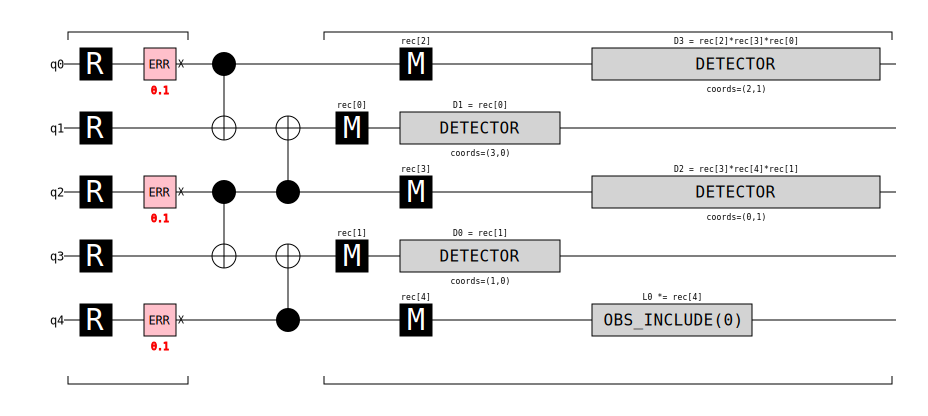

In [17]:
ckt = repetition_code_circuit(3, 0.1)
ckt.diagram('timeline-svg')

stim.DetectorErrorModel('''
    error(0.1) D0 D1
    error(0.1) D0 L0
    error(0.1) D1
    detector(1, 0) D0
    detector(3, 0) D1
    detector(0, 1) D2
    detector(2, 1) D3
''')


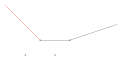

In [19]:
dem = ckt.detector_error_model()
print(repr(dem))
dem.diagram('matchgraph-svg')

In [42]:
shots = 10_000
ds = np.array([3, 5, 7])
ps = np.linspace(0.1, 0.5, num=7)
pymatching_lers = np.zeros((ds.size, ps.size))
my_lers = np.zeros((ds.size, ps.size))

for i, d in enumerate(ds):
    print(f"d={d}")
    for j, p in enumerate(ps):
        num_errors_pymatching = count_logical_errors_pymatching(d, p, shots)
        pymatching_lers[i, j] = float(num_errors_pymatching) / float(shots)
        num_errors_me = count_logical_errors_my_decoder(d, p, shots)
        my_lers[i,j] = float(num_errors_me) / float(shots)

d=3
d=5
d=7


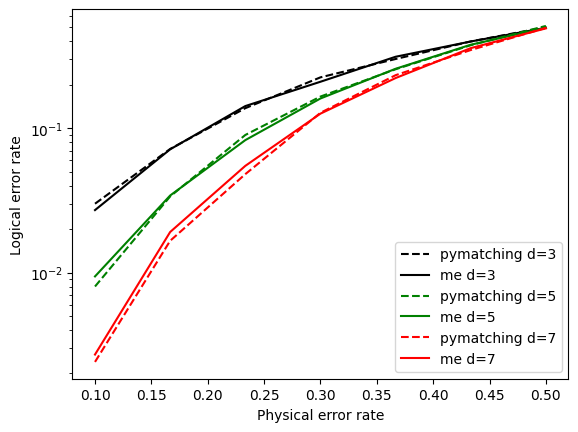

In [44]:
fig, ax = plt.subplots()
colors = ['k', 'g', 'r']
for i, (d, color) in enumerate(zip(ds, colors)):
    ax.plot(ps, pymatching_lers[i, :], '--', color=color, label=f"pymatching d={d}")
    ax.plot(ps, my_lers[i, :], '-', color=color, label=f"me d={d}")
ax.set_yscale('log')
plt.legend()
ax.set_xlabel("Physical error rate")
ax.set_ylabel("Logical error rate")
plt.savefig("../repetition_mwpm_ler.pdf")